In [13]:
import os

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np
import xarray as xr
import rioxarray as rxr
import earthpy as et
import earthpy.plot as ep

In [14]:
from shapely import geometry

In [15]:
from PIL import Image, ImageDraw

In [16]:
from osgeo import gdal
from osgeo import ogr
from osgeo import osr

In [17]:
import copy

In [19]:
import shapefile
shape = shapefile.Reader("Konstantinovky_TestReg_MainObjectsMap.shp")

In [20]:
polygons_list = shape.shapes()

In [21]:
polygons_list

Shapes: [<shapefile.Shape object at 0x000002CE2AFFEC88>, <shapefile.Shape object at 0x000002CE2AFFEF08>, <shapefile.Shape object at 0x000002CE2B000148>, <shapefile.Shape object at 0x000002CE2B000288>, <shapefile.Shape object at 0x000002CE2B0008C8>, <shapefile.Shape object at 0x000002CE2B000F08>, <shapefile.Shape object at 0x000002CE2B004508>]

In [22]:
polygons_list[0].points

[(317687.8797882477, 6304352.108486575),
 (318179.8061966207, 6304351.799633077),
 (318177.33536863956, 6304315.972627351),
 (318166.21664272435, 6304288.175812563),
 (318153.2447958233, 6304243.083201907),
 (318137.18441394577, 6304217.757215099),
 (318137.80212094105, 6304181.312502378),
 (318127.3011020212, 6304143.01466867),
 (318122.35944605886, 6304131.895942755),
 (318097.6511662473, 6304108.423076934),
 (318074.7960074216, 6304083.714797122),
 (318045.14607164776, 6304055.300275339),
 (318032.791931742, 6304046.652377405),
 (318011.7898939022, 6304040.475307452),
 (317993.25868404354, 6304042.328428438),
 (317983.3753721189, 6304047.887791395),
 (317977.198302166, 6304092.9804020515),
 (317962.9910412744, 6304105.952248952),
 (317964.84416226024, 6304136.837598717),
 (317957.76843007747, 6304151.285094656),
 (317945.1516519785, 6304153.226137441),
 (317926.5077218643, 6304169.749799557),
 (317920.33065191144, 6304168.514385566),
 (317922.8400865806, 6304126.336579797),
 (317935

In [23]:
konstantinovky = rxr.open_rasterio("Konstantinovky_TestReg_pan.tif")

In [24]:
konstantinovky

<xarray.DataArray (band: 1, y: 1694, x: 1793)>
[3037342 values with dtype=float32]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 3.177e+05 3.177e+05 ... 3.186e+05 3.186e+05
  * y            (y) float64 6.304e+06 6.304e+06 ... 6.304e+06 6.304e+06
    spatial_ref  int32 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [25]:
konst_gdal = gdal.Open ("Konstantinovky_TestReg_pan.tif" )
geo_trans = konst_gdal.GetGeoTransform()
prj = konst_gdal.GetProjection()

In [26]:
konst_gdal

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x000002CE2938C270> >

In [27]:
prj

'PROJCS["WGS 84 / UTM zone 37N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",39],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32637"]]'

In [28]:
geo_trans

(317689.0, 0.5, 0.0, 6304351.0, 0.0, -0.5)

In [29]:
def coord2pix_new(ds, coordinates_list): 
    geo_trans = ds.GetGeoTransform()
    x = np.array([coord[0] for coord in coordinates_list])
    y = np.array([coord[1] for coord in coordinates_list])
    ul_x = geo_trans[0]
    ul_y = geo_trans[3]
    x_dist = geo_trans[1]
    y_dist = geo_trans[5]
    if len(x) > 0: 
        pixel = ((-x * geo_trans[5] + y * geo_trans[2] + geo_trans[0] * geo_trans[5] - geo_trans[2] * geo_trans[3])/(geo_trans[2] * geo_trans[4] - geo_trans[1] * geo_trans[5])).astype(int) 
        line = ((x * geo_trans[4] - y * geo_trans[1] + geo_trans[1] * geo_trans[3] - geo_trans[0] * geo_trans[4])/(geo_trans[2] * geo_trans[4] - geo_trans[1] * geo_trans[5])).astype(int)
        pixel[pixel < 0] = 0
        line[line < 0] = 0
        pixel[pixel > 1793] = 1793
        line[line > 1694] = 1694
        output = list(zip(pixel, line)) 
    else: 
        output = [] 
    return output 

def coord2pix(coordinates_list, geo_trans, projection_ref, to_round_result=True): 
    spatial_reference = osr.SpatialReference() 
    spatial_reference.ImportFromWkt(projection_ref) 
    crsGeo = osr.SpatialReference() 
    crsGeo.ImportFromEPSG(4326) 
    transformer_in_shot_world_coordinates = osr.CoordinateTransformation(crsGeo, spatial_reference) 
    coords = transformer_in_shot_world_coordinates.TransformPoints(coordinates_list) 
    if len(coords) > 0: 
        x_coords = np.array(coords)[:, 0] 
        y_coords = np.array(coords)[:, 1] 
 
        x_pix = (-x_coords * geo_trans[5] + y_coords * geo_trans[2] + geo_trans[0] * geo_trans[5] - geo_trans[2] * geo_trans[3]) / (geo_trans[2] * geo_trans[4] - geo_trans[1] * geo_trans[5]) 
        y_pix = (x_coords * geo_trans[4] - y_coords * geo_trans[1] + geo_trans[1] * geo_trans[3] - geo_trans[0] * geo_trans[4]) /  (geo_trans[2] * geo_trans[4] - geo_trans[1] * geo_trans[5]) 
        if to_round_result: 
            x_pix = np.round(x_pix) 
            y_pix = np.round(y_pix) 
        output = list(zip(x_pix, y_pix)) 
    else: 
        output = [] 
    return output 


# Extract target reference from the tiff file
ds = gdal.Open("Konstantinovky_TestReg_pan.tif")

In [30]:
def pix2coord(pix_coordinates_list, geo_trans, projection_ref): 
    srs = osr.SpatialReference() 
    srs.ImportFromWkt(projection_ref) 
    ct = osr.CoordinateTransformation(srs, srs.CloneGeogCS()) 
    if len(pix_coordinates_list) > 0: 
        x = np.array(pix_coordinates_list)[:, 0] 
        y = np.array(pix_coordinates_list)[:, 1] 
        lon_list = x * geo_trans[1] + geo_trans[0] 
        lat_list = y * geo_trans[5] + geo_trans[3] 
        lon_final_list = [] 
        lat_final_list = [] 
        for i in range(0, len(lon_list)): 
            (lon, lat, holder) = ct.TransformPoint(lon_list[i], lat_list[i]) 
            lon_final_list.append(lon) 
            lat_final_list.append(lat) 
        output = list(zip(lon_final_list, lat_final_list)) 
    else: 
        output = [] 
    return output

In [31]:
def to_clip_shot(image, polygon, geo_trans, projection_ref):
    # новая геопривязка для вырезанного снимка
    new_geo_trans = list(copy.deepcopy(geo_trans))
    new_image = copy.deepcopy(image)#[min_y_pix: max_y_pix, min_x_pix: max_x_pix]) this line was edited by me
    new_geo_trans = tuple(new_geo_trans)
    new_border_points = coord2pix(polygon.points, new_geo_trans, projection_ref)
    new_x_shot_size = len(new_image[0, 0])
    new_y_shot_size = len(new_image[0])
    mask_im = Image.new('L', (new_x_shot_size, new_y_shot_size), 0)
    ImageDraw.Draw(mask_im).polygon(new_border_points, outline=1, fill=1)
    mask = np.array(mask_im)
    for i in range(len(new_image)):
        new_image[i] = new_image[i] * mask
    return new_image, new_geo_trans

In [32]:
points = polygons_list[0].points
points = coord2pix_new(konst_gdal, points)
points = pix2coord(points, geo_trans, prj)
polygons_list[0].points = points

In [33]:
image_polygon1, image_polygon1_geo_trans = to_clip_shot(konstantinovky, polygons_list[0], geo_trans, prj)

In [34]:
image_polygon1

<xarray.DataArray (band: 1, y: 1694, x: 1793)>
[3037342 values with dtype=float32]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 3.177e+05 3.177e+05 ... 3.186e+05 3.186e+05
  * y            (y) float64 6.304e+06 6.304e+06 ... 6.304e+06 6.304e+06
    spatial_ref  int32 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [35]:
image_polygon1.values[image_polygon1.values != 0] = 1

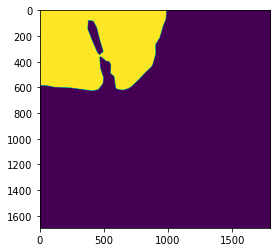

In [36]:
plt.imshow(image_polygon1[0, :, :])

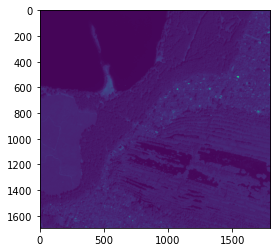

In [37]:
plt.imshow(konstantinovky.values[0, :, :])

In [38]:
points = polygons_list[1].points
points = coord2pix_new(konst_gdal, points)
points = pix2coord(points, geo_trans, prj)
polygons_list[1].points = points

In [39]:
image_polygon2, image_polygon2_geo_trans = to_clip_shot(konstantinovky, polygons_list[1], geo_trans, prj)

In [40]:
image_polygon2

<xarray.DataArray (band: 1, y: 1694, x: 1793)>
array([[[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]]], dtype=float32)
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 3.177e+05 3.177e+05 ... 3.186e+05 3.186e+05
  * y            (y) float64 6.304e+06 6.304e+06 ... 6.304e+06 6.304e+06
    spatial_ref  int32 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

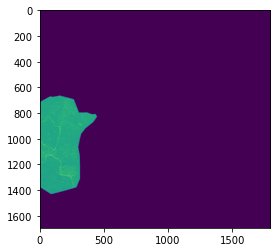

In [41]:
plt.imshow(image_polygon2[0, :, :])

In [42]:
image_polygon2.values[image_polygon2.values != 0] = 2

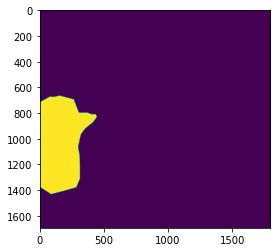

In [43]:
plt.imshow(image_polygon2[0, :, :])

In [44]:
points = polygons_list[2].points
points = coord2pix_new(konst_gdal, points)
points = pix2coord(points, geo_trans, prj)
polygons_list[2].points = points
image_polygon3, image_polygon3_geo_trans = to_clip_shot(konstantinovky, polygons_list[2], geo_trans, prj)

In [45]:
image_polygon3

<xarray.DataArray (band: 1, y: 1694, x: 1793)>
array([[[  0.,   0., ...,   0.,   0.],
        [  0.,   0., ...,   0.,   0.],
        ...,
        [229., 232., ...,   0.,   0.],
        [257., 262., ...,   0.,   0.]]], dtype=float32)
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 3.177e+05 3.177e+05 ... 3.186e+05 3.186e+05
  * y            (y) float64 6.304e+06 6.304e+06 ... 6.304e+06 6.304e+06
    spatial_ref  int32 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

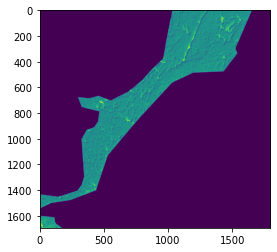

In [46]:
plt.imshow(image_polygon3[0, :, :])

In [47]:
image_polygon3.values[image_polygon3.values != 0] = 3

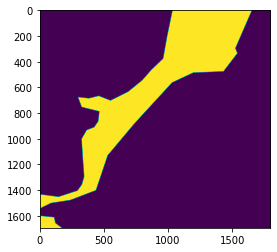

In [48]:
plt.imshow(image_polygon3[0, :, :])

In [49]:
polygons_list

Shapes: [<shapefile.Shape object at 0x000002CE2AFFEC88>, <shapefile.Shape object at 0x000002CE2AFFEF08>, <shapefile.Shape object at 0x000002CE2B000148>, <shapefile.Shape object at 0x000002CE2B000288>, <shapefile.Shape object at 0x000002CE2B0008C8>, <shapefile.Shape object at 0x000002CE2B000F08>, <shapefile.Shape object at 0x000002CE2B004508>]

In [50]:
points = polygons_list[3].points
points = coord2pix_new(konst_gdal, points)
points = pix2coord(points, geo_trans, prj)
polygons_list[3].points = points
image_polygon4, image_polygon4_geo_trans = to_clip_shot(konstantinovky, polygons_list[3], geo_trans, prj)

In [51]:
image_polygon4.values[image_polygon4.values != 0] = 4

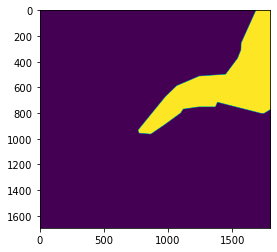

In [52]:
plt.imshow(image_polygon4[0, :, :])

In [53]:
points = polygons_list[4].points
points = coord2pix_new(konst_gdal, points)
points = pix2coord(points, geo_trans, prj)
polygons_list[4].points = points
image_polygon5, image_polygon5_geo_trans = to_clip_shot(konstantinovky, polygons_list[4], geo_trans, prj)

In [54]:
image_polygon5.values[image_polygon5.values != 0] = 4

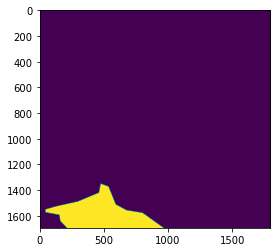

In [55]:
plt.imshow(image_polygon5[0, :, :])

In [56]:
points = polygons_list[5].points
points = coord2pix_new(konst_gdal, points)
points = pix2coord(points, geo_trans, prj)
polygons_list[5].points = points
image_polygon6, image_polygon6_geo_trans = to_clip_shot(konstantinovky, polygons_list[5], geo_trans, prj)

In [57]:
image_polygon6.values[image_polygon6.values != 0] = 5

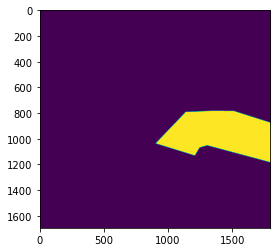

In [58]:
plt.imshow(image_polygon6[0, :, :])

In [59]:
points = polygons_list[6].points
points = coord2pix_new(konst_gdal, points)
points = pix2coord(points, geo_trans, prj)
polygons_list[6].points = points
image_polygon7, image_polygon7_geo_trans = to_clip_shot(konstantinovky, polygons_list[6], geo_trans, prj)

In [60]:
image_polygon7.values[image_polygon7.values != 0] = 5

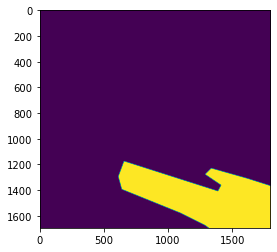

In [61]:
plt.imshow(image_polygon7[0, :, :])

In [62]:
final_pattern = image_polygon1.values + image_polygon2.values + image_polygon3.values + image_polygon4.values + image_polygon5.values + image_polygon6.values + image_polygon7.values

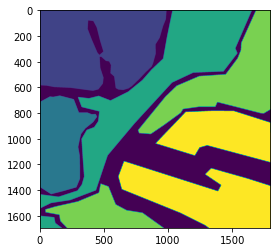

In [63]:
plt.imshow(final_pattern[0, :, :])

In [65]:
map_konstantinovsky = final_pattern.squeeze()

In [69]:
rows, cols = map_konstantinovsky.shape[0], map_konstantinovsky.shape[1]
ds = gdal.Open("Konstantinovky_TestReg_pan.tif")
outFileName = "Konstantinovsky_map.tif"
driver = gdal.GetDriverByName("GTiff")
outdata = driver.Create(outFileName, cols, rows, 1, gdal.GDT_UInt16)
outdata.SetGeoTransform(ds.GetGeoTransform())##sets same geotransform as input
outdata.SetProjection(ds.GetProjection())##sets same projection as input
outdata.GetRasterBand(1).WriteArray(map_konstantinovsky)
outdata.FlushCache()

In [94]:
np.save('Konstantinovky_map', map_konstantinovky)